<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/1/MLP_Basics_ModelEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from matplotlib import rcParams
# rcParams['figure.figsize'] = 15,7
plt.rc('figure', figsize=(12,7) )         # Image size

import seaborn as sns

import io, requests

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 10 )

plt.rc('figure', figsize=(10,5) )         # Image size

In [3]:
def grid(x1, x2, off_set = .1, n_points = 100):
    ## d s show the range in the two varible. 
    d1 = x1.max() - x1.min()
    d2 = x2.max() - x2.min()
    
    x1_min, x1_max = x1.min() - off_set * d1 , x1.max() + off_set * d1
    x2_min, x2_max = x2.min() - off_set * d2 , x2.max() + off_set * d2

    ## This function from numpy gives a list of coordinates that are the points on the grid. 
    x, y = np.meshgrid(np.arange(x1_min, x1_max , d1/n_points), np.arange(x2_min, x2_max , d2/n_points) )

    return x , y 

# Good fit vs good model

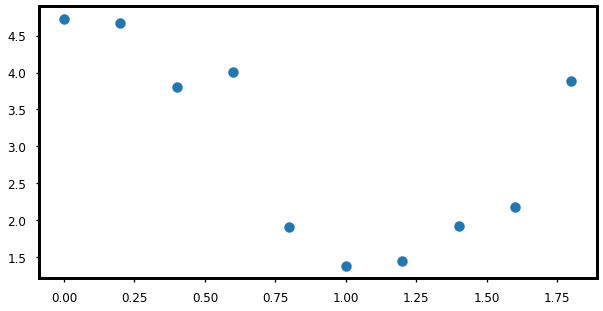

In [ ]:
'''
We first need some data. Let's make some.
'''
eps = .5  # The amplitude of the noise. 
w_real = np.array([3, -6, 1, 4])
pol_feature = lambda x, deg: np.hstack([x**(deg-d) for d in np.arange(deg+1) ])
func = lambda x, w: w @ pol_feature(x, 3)

x_list = np.arange(0,2,.2).reshape(-1,1)
y_list = [func(x, w_real) + np.random.normal(0,eps) for x in x_list]

plt.scatter(x_list, y_list);

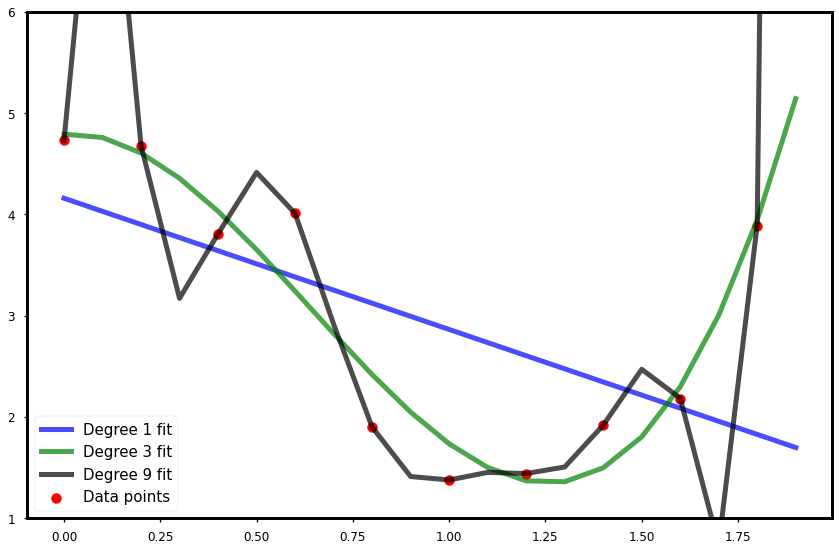

In [ ]:
x_range = np.arange(0,2,.1).reshape(-1,1)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1 )
ax.scatter(x_list, y_list, s = 100, c = 'r', label='Data points')

deg_list = [1,3,9]
col_list = ['b', 'g', 'black']
ind = -1
for deg in deg_list:
  ind +=1
    ## Make the X matrix with powers of the x
  x_rg_in = pol_feature(x_list, deg)

  ## Construct m as X^T.X
  m = np.dot(x_rg_in.T,x_rg_in)

  ## This gives the w
  w = np.dot(np.linalg.inv(m),np.dot(x_rg_in.T, y_list))  

  ## Add the plot
  y_rg_list = np.dot(pol_feature(x_range, deg), w)
  
  ax.plot(x_range, y_rg_list, alpha=.7, c = col_list[ind], label=f'Degree {deg} fit')
    

plt.ylim((1,6))
plt.legend()
plt.tight_layout()
plt.show()    

# Bias and Variance

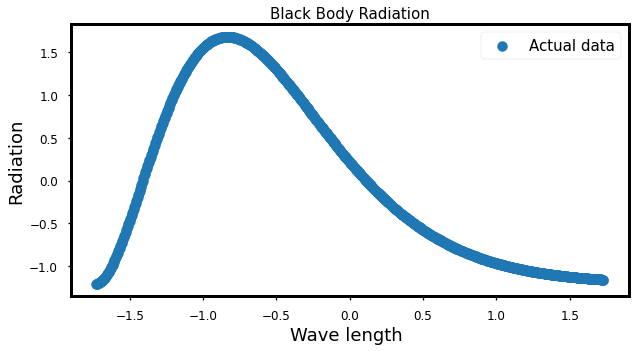

In [4]:
#####BBR###### 
## This data is collected from galileo.phys.virginia.edu/classes/252
url = "https://github.com/sraeisi/MachineLearning_Physics/blob/master/Data/bbr.xls?raw=true"
data_bbr = pd.read_excel(url)


from sklearn.preprocessing import scale
# n_s_rate = 20

X_bbr = scale(data_bbr[0])
Y_bbr = scale(data_bbr['T'])

x_label = 'Wave length '
y_label = 'Radiation'
plt_title = 'Black Body Radiation'
fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
ax.scatter(X_bbr, Y_bbr, label = 'Actual data')

ax.legend()
plt.show()

## Model complexity

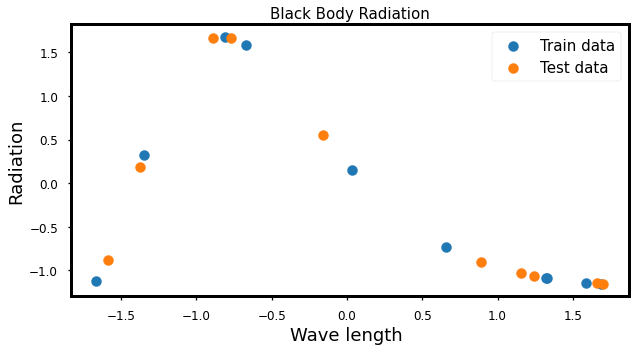

In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
ns = 20
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, label = 'Test data')

ax.legend()
plt.show()

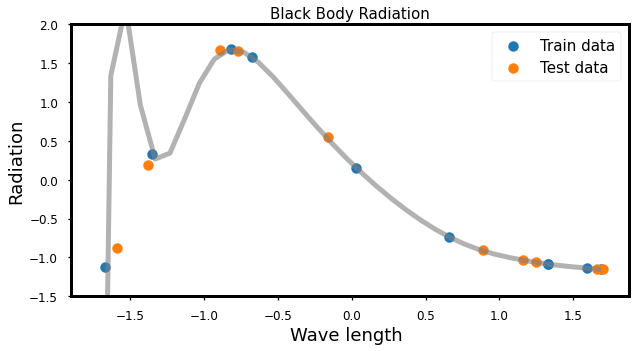

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
deg = 15
rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
rg.fit( X_train.reshape(-1,1), Y_train )

x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)
y_range = rg.predict(x_range.reshape(-1,1) )


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, label = 'Test data')
ax.plot(x_range, y_range, c = 'gray', alpha = .6)

ax.legend()
# plt.yscale('log')
plt.ylim(-1.5,2)
plt.show()

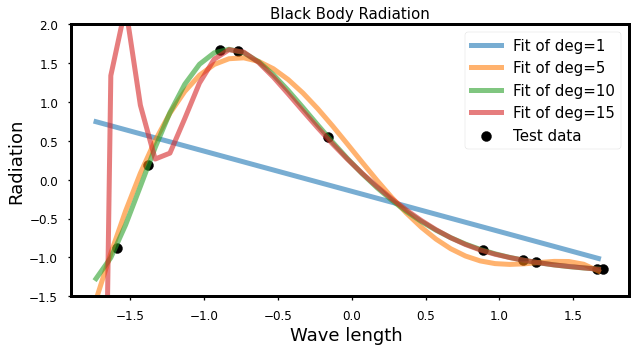

In [10]:
deg_list = [1,5,  10, 15]


x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')
for deg in deg_list:
  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_range = rg.predict(x_range.reshape(-1,1) )

  ax.plot(x_range, y_range,  alpha = .6, label=f'Fit of deg={deg}')

ax.legend()
plt.ylim(-1.5,2)

plt.show()

### Validation Curve

How much complexity?

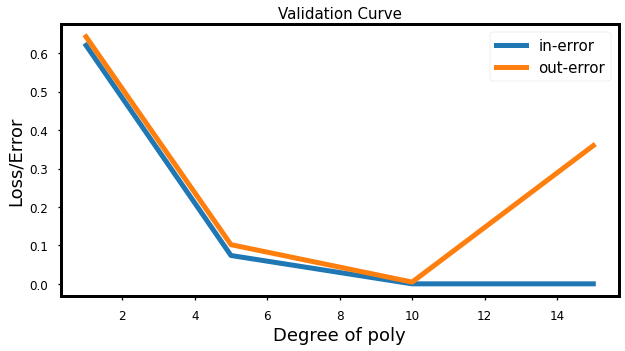

In [11]:
in_err_list = []
out_err_list = []

for deg in deg_list:
  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_pred = rg.predict(X_train.reshape(-1,1) )
  in_err_list += [np.abs(Y_train-y_pred).sum()/len(Y_train) ]

  y_pred = rg.predict(X_test.reshape(-1,1) )
  out_err_list += [np.abs(Y_test-y_pred).sum()/len(Y_test) ]


in_err_list = np.array(in_err_list)
out_err_list = np.array(out_err_list)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='Degree of poly', ylabel='Loss/Error', title='Validation Curve')

plt.plot(deg_list, in_err_list, label = 'in-error');
plt.plot(deg_list, out_err_list, label = 'out-error');

plt.legend()
# plt.yscale('log')
plt.show()

In [17]:
# out_err_list- in_err_list
in_err_list

array([6.20532287e-01, 7.37640699e-02, 1.70141679e-15, 7.84400322e-14])

## Data

In [18]:
ns = 200
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )


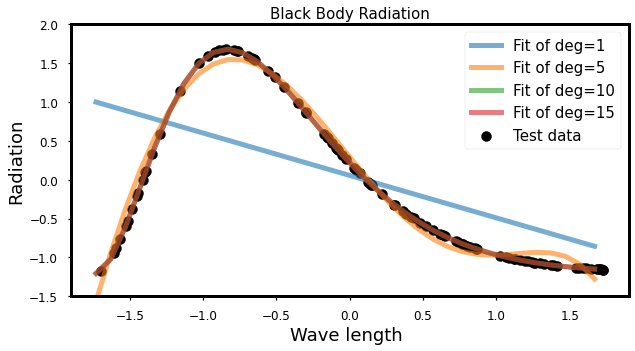

In [19]:
deg_list = [1,5,  10, 15]


x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')
for deg in deg_list:
  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_range = rg.predict(x_range.reshape(-1,1) )

  ax.plot(x_range, y_range,  alpha = .6, label=f'Fit of deg={deg}')

ax.legend()
plt.ylim(-1.5,2)

plt.show()

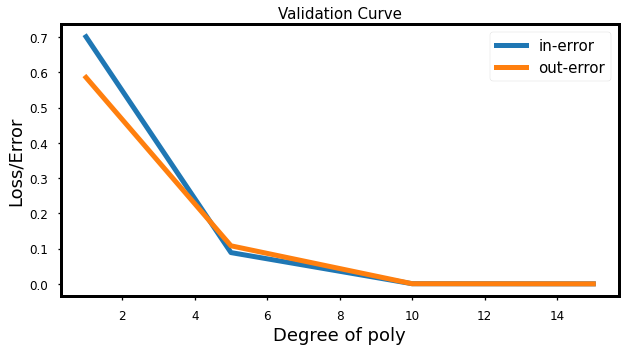

In [20]:
in_err_list = []
out_err_list = []

for deg in deg_list:
  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_pred = rg.predict(X_train.reshape(-1,1) )
  in_err_list += [np.abs(Y_train-y_pred).sum()/len(Y_train) ]

  y_pred = rg.predict(X_test.reshape(-1,1) )
  out_err_list += [np.abs(Y_test-y_pred).sum()/len(Y_test) ]


in_err_list = np.array(in_err_list)
out_err_list = np.array(out_err_list)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='Degree of poly', ylabel='Loss/Error', title='Validation Curve')

plt.plot(deg_list, in_err_list, label = 'in-error');
plt.plot(deg_list, out_err_list, label = 'out-error');
plt.legend()
# plt.yscale('log')
plt.show()

In [23]:
out_err_list-in_err_list

array([-1.15343510e-01,  1.92401941e-02,  5.07460486e-05,  2.64677726e-07])

### Learning curve

How can we check if we have enough data?

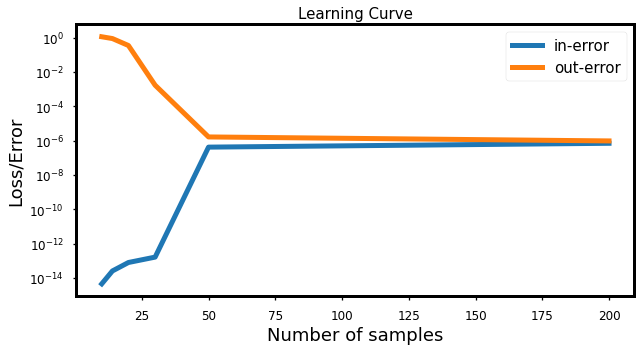

In [24]:
deg = 15
ns_list = [ 10, 14, 20, 30, 50,  200]

in_err_list = []
out_err_list = []

for ns in ns_list:
  X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )

  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_pred = rg.predict(X_train.reshape(-1,1) )
  in_err_list += [np.abs(Y_train-y_pred).sum()/len(Y_train) ]

  y_pred = rg.predict(X_test.reshape(-1,1) )
  out_err_list += [np.abs(Y_test-y_pred).sum()/len(Y_test) ]


in_err_list = np.array(in_err_list)
out_err_list = np.array(out_err_list)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='Number of samples', ylabel='Loss/Error', title='Learning Curve')

plt.plot(ns_list, in_err_list, label = 'in-error');
plt.plot(ns_list, out_err_list, label = 'out-error');
plt.legend()
plt.yscale('log')
plt.show()

## Regularization

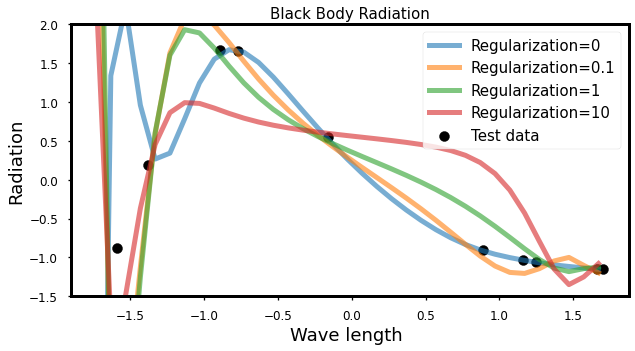

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.linear_model import Ridge


deg_list = 20
ns = 20
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )


w_list = []

x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')


r_list = [0, .1,1,10]
for r in r_list:

  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), 
                ('model', Ridge( alpha=r ) ### We are using Ridge which uses l2 regularization. 
                )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  ### Let's store the weights
  w_list += [rg[1].coef_]

  y_range = rg.predict(x_range.reshape(-1,1) )
  ax.plot(x_range, y_range,  alpha = .6, label=f'Regularization={r}')


w_list = np.array(w_list)
plt.ylim(-1.5,2)
ax.legend()
plt.show()

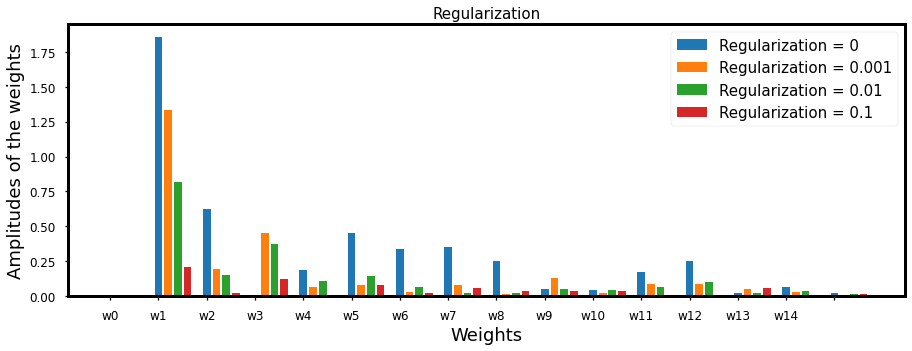

In [ ]:
# w_list.shape
x_ticks = np.arange(0,(deg+1)*(len(r_list)+1), 1 + len(r_list))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, xlabel='Weights', ylabel='Amplitudes of the weights', title='Regularization')
for i in range(len(r_list)):
  ax.bar(x_ticks+i, np.abs(w_list)[i], label=f'Regularization = {r_list[i]}')

plt.legend()
plt.xticks( (len(r_list)+1)*np.arange( len(w_list[0]) ) , labels= [f'w{i}' for i in np.arange(0, deg,1)])
plt.show()

### L1 vs L2 regularization

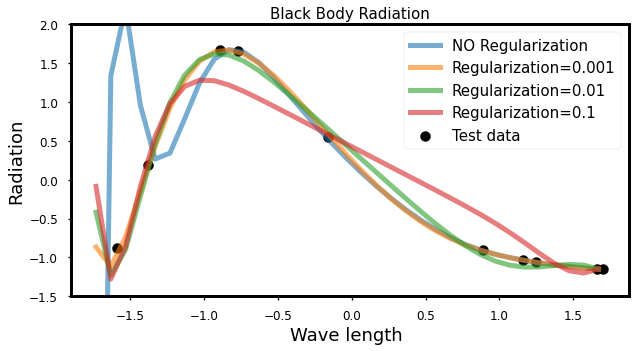

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.linear_model import Lasso


deg_list = 20
ns = 20
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )


w_list_lasso = []

x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')


rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), 
              ('model', LinearRegression( ) ### We are using Ridge which uses l2 regularization. 
              )])
rg.fit( X_train.reshape(-1,1), Y_train )

### Let's store the weights
w_list_lasso += [rg[1].coef_]

y_range = rg.predict(x_range.reshape(-1,1) )
ax.plot(x_range, y_range,  alpha = .6, label=f'NO Regularization')


r_list = [.001,.01,.1]
for r in r_list:

  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), 
                ('model', Lasso( alpha=r ) ### We are using Ridge which uses l2 regularization. 
                )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  ### Let's store the weights
  w_list_lasso += [rg[1].coef_]

  y_range = rg.predict(x_range.reshape(-1,1) )
  ax.plot(x_range, y_range,  alpha = .6, label=f'Regularization={r}')


w_list_lasso = np.array(w_list_lasso)
plt.ylim(-1.5,2)
ax.legend()
plt.show()

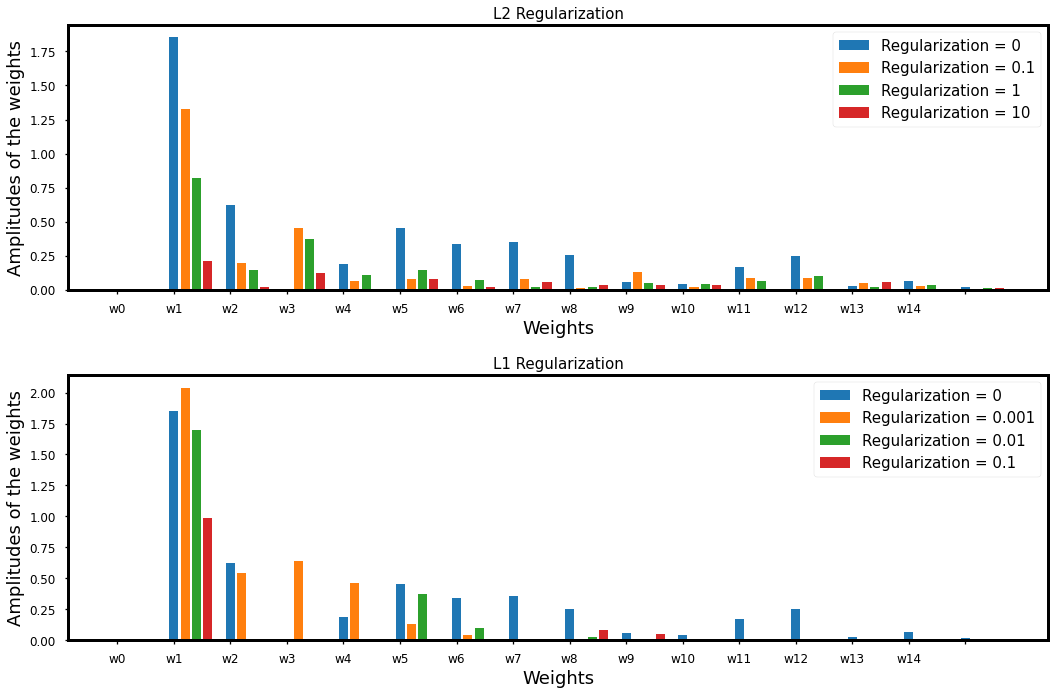

In [ ]:
# w_list.shape
x_ticks = np.arange(0,( deg+1 )*(len(r_list)+1), 1 + len(r_list))
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211, xlabel='Weights', ylabel='Amplitudes of the weights', title='L2 Regularization')
r_list = [0, .1, 1, 10]
for i in range(len(r_list)):
  ax.bar(x_ticks+i, np.abs(w_list)[i], label=f'Regularization = {r_list[i]}')

plt.legend()
plt.xticks( (len(r_list)+1)*np.arange( len(w_list[0]) ) , labels= [f'w{i}' for i in np.arange(0, deg,1)])

ax = fig.add_subplot(212, xlabel='Weights', ylabel='Amplitudes of the weights', title='L1 Regularization')

r_list = [0, .001,.01,.1]
for i in range(len(r_list)):
  ax.bar(x_ticks+i, np.abs(w_list_lasso)[i], label=f'Regularization = {r_list[i]}')

plt.legend()
plt.xticks( (len(r_list)+1)*np.arange( len(w_list[0]) ) , labels= [f'w{i}' for i in np.arange(0, deg,1)])

plt.tight_layout()
plt.show()

# Recap

In [ ]:
url = 'https://raw.githubusercontent.com/sraeisi/Machine_Learning_Physics_Winter20/master/Lec1/particle_mini.npz'
s=requests.get(url, stream=True).content
data=np.load(io.BytesIO(s) )
X, Y = data['X'], data['Y']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X , Y, random_state=0)


from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### Training the model
clf_pipeline= Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = 3)), 
                        ('clf', SGDClassifier())])
clf_pipeline.fit(X_train,Y_train)

### Testing the model
y_predict = clf_pipeline.predict(X_test)
out_error = np.abs(Y_test - y_predict).sum() / len(Y_test)

in_error = np.abs(Y_train - clf_pipeline.predict(X_train)  ).sum() / len(Y_train)

print(f'The in-sample error is {in_error:.4f}, and the out_sample error is {out_error:.4f}.')

The in-sample error is 0.0316, and the out_sample error is 0.0357.


In [ ]:
from joblib import dump, load
dump(clf_pipeline, 'pipeline')

['pipeline']

In [ ]:
model = load('pipeline')
model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

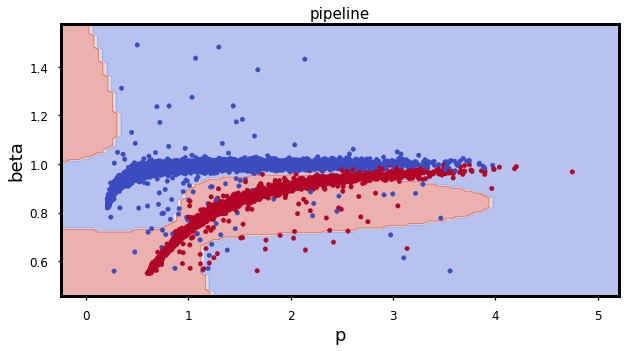

In [ ]:
x1_list, x2_list = grid(X[:,0], X[:,1], n_points=100)
X_grid = np.vstack([x1_list.reshape(-1),x2_list.reshape(-1)]).T

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1 , xlabel = 'p', ylabel='beta', title = 'pipeline')
Y_grid = model.predict( X_grid ).reshape(x1_list.shape )

ax.contourf(x1_list, x2_list, Y_grid, alpha=.4, cmap=plt.cm.coolwarm)
ax.scatter(*X.T, c=Y, cmap=plt.cm.coolwarm, s=20)    
plt.show()